# Classifier for CEFR Levels

In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Convolution1D, MaxPooling1D, Dropout, Flatten, BatchNormalization

Using Theano backend.


In [85]:
import numpy as np
import string
import cPickle as pickle
import re
import pandas as pd
import itertools
import bcolz
import os
from collections import defaultdict
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from __future__ import division

In [4]:
data_path = 'data/sentences/'

In [5]:
%matplotlib inline

In [6]:
model_path = 'data/models'

In [7]:
cefr_levels = ['a1','a2','b1','b2']

## Sort data into train, valid, and test sets

In [ ]:
%pwd

In [ ]:
%mkdir data/train
%mkdir data/valid
%mkdir data/test

In [8]:
train_path = 'data/train/'
valid_path = 'data/valid/'
test_path =  'data/test/'

In [9]:
def process_line(line):
    raw = line.strip().decode('unicode_escape').encode('ascii','ignore')
    words = re.findall(r"\w+|[^\w\s]", raw, re.UNICODE)
    return [word.lower() for word in words]

## Make a first pass through the data to create an index of all words used.

In [10]:
base_file = '_sentences.txt'
idx = defaultdict(int)
for l in range(len(cefr_levels)):
    with open(data_path + cefr_levels[l] + base_file,'r') as f:
        for line in f:
            words = process_line(line)
            for word in words:
                idx[word] += 1

final_words = sorted(idx.items(), key=lambda x: x[1])
final_words.reverse()
print(final_words[:50])
idx2word = [ i[0] for i in final_words ]
word2idx = dict((v,k) for k,v in enumerate(idx2word))

pickle.dump(idx2word,  open(data_path + "idx2word.p", 'wb'))
pickle.dump(word2idx,  open(data_path + "word2idx.p", 'wb'))

[('.', 15372), ('the', 12689), (',', 12559), ('to', 6580), ('and', 5894), ('of', 5629), ('a', 5283), ('i', 3822), ('in', 3132), ('you', 2981), ('that', 2808), ('he', 2681), ('it', 2551), ('said', 2160), ('is', 2109), ('was', 1937), ('?', 1790), ('be', 1784), ("'", 1689), ('as', 1591), ('not', 1579), ('for', 1537), ('but', 1524), ('at', 1504), ('have', 1492), ('if', 1443), ('his', 1415), ('on', 1273), ('with', 1264), ('they', 1238), ('she', 1210), ('do', 1201), ('we', 1180), ('this', 1127), ('what', 1037), ('will', 1023), ('looked', 1017), ('her', 1011), ('!', 1008), ('had', 972), ('are', 962), ('-', 953), ('all', 903), ('its', 792), ('up', 783), ('were', 779), ('by', 747), ('so', 735), ('from', 729), ('an', 723)]


In [15]:
train_share = 0.65
valid_share = 0.2
test_share = 0.15
assert train_share + valid_share + test_share == 1

In [172]:
base_file = '_sentences.txt'
total_count = 0
train = np.empty((1,2),dtype='object')
valid = np.empty((1,2),dtype='object')
test  = np.empty((1,2),dtype='object')
for l in range(len(cefr_levels)):
    level = []
    with open(data_path + cefr_levels[l] + base_file,'r') as f:
        for line in f:
            words = process_line(line)
            level.append((words,l))
    count = len(level)
    total_count += count
    print(cefr_levels[l],count)
    train_idx = int(train_share * count)
    valid_idx = int(valid_share * count) + train_idx
    shuf = np.random.permutation(level)
    train = np.concatenate((train, shuf[:train_idx]))
    valid = np.concatenate((valid, shuf[train_idx:valid_idx]))
    test  = np.concatenate((test,  shuf[valid_idx:]))

pickle.dump(np.random.permutation(train[1:]), open(train_path + "sentences.p", 'wb'))  
pickle.dump(np.random.permutation(valid[1:]), open(valid_path + "sentences.p", 'wb'))
pickle.dump(np.random.permutation(test[1:]),  open(test_path + "sentences.p", 'wb'))

print(total_count)

('a1', 2487)
('a2', 5110)
('b1', 6371)
('b2', 4806)
18774


### Load and process data

In [173]:
idx2word = pickle.load(open(data_path + "idx2word.p", 'rb'))
word2idx = pickle.load(open(data_path + "word2idx.p", 'rb'))

train_file = pickle.load(open(train_path + 'sentences.p','rb'))
valid_file = pickle.load(open(valid_path + 'sentences.p','rb'))
test_file  = pickle.load(open(test_path + 'sentences.p','rb'))

train, train_labels = zip(*train_file)
valid, valid_labels = zip(*valid_file)
test, test_labels   = zip(*test_file)

In [174]:
assert len(train) + len(valid) + len(test) == total_count

## Limit vocab size

In [175]:
vocab_size = 5000
train = [np.array([word2idx[i] if word2idx[i] <= vocab_size-1 else vocab_size-1 for i in line ]) for line in train]
valid = [np.array([word2idx[i] if word2idx[i] <= vocab_size-1 else vocab_size-1 for i in line ]) for line in valid]
test  = [np.array([word2idx[i] if word2idx[i] <= vocab_size-1 else vocab_size-1 for i in line ]) for line in test]

## Data augmentation (experimental and apparently useless)

In [68]:
subs = {
    'dog':'cat',
    'cat':'dog',
    'he':'she',
    'she':'he',
    'him':'her',
    'her':'him',
    'this':'that',
    'that':'this',
    'these':'those',
    'those':'these',
    'like':'love',
    'likes':'loves',
    'is':'was',
    'was':'is',
    'have':'had',
    'had':'have'
}

In [69]:
sub2idx = {word2idx[key]: word2idx[value] for key,value in subs.iteritems()}
dogidx = word2idx['dog']
assert sub2idx[dogidx] == word2idx['cat']

In [70]:
def augment_line(line):
    augmented = []
    for word in line:
        if word in sub2idx:
            augmented.append(sub2idx[word])
        else:
            augmented.append(word)
    return augmented

In [71]:
train_aug = []
train_labels_aug = []
for i in range(len(train)):
    line = train[i]
    augmented = augment_line(line)
    if not np.array_equal(augmented,line):
        train_aug.append(augmented)
        train_labels_aug.append(train_labels[i])
train_aug = np.concatenate((train, train_aug))
train_labels_aug = np.concatenate((train_labels,train_labels_aug))

In [72]:
print(len(train_aug))

18690


In [179]:
' '.join(idx2word[i] for i in train[0])

'in this connection it is worth wrinkled the wrinkled of the great theoretical physicist j .'

## Use one-hot encoding on the labels:

In [177]:
train_labels = to_categorical(train_labels)
valid_labels = to_categorical(valid_labels)
test_labels = to_categorical(test_labels)
#train_labels_aug = to_categorical(train_labels_aug)

In [178]:
train_labels[0]

array([ 0.,  0.,  0.,  1.])

### Make sure all sets have the same ratios of each of the 4 CEFR labels.

In [180]:
def check_ratios(labels):
    length = float(len(labels))
    a1 = sum(labels[i][0] for i in range(len(labels)))
    a2 = sum(labels[i][1] for i in range(len(labels)))
    b1 = sum(labels[i][2] for i in range(len(labels)))
    b2 = sum(labels[i][3] for i in range(len(labels)))
    return (a1 / length, a2 / length, b1 / length, b2 / length)

In [181]:
ratios = check_ratios(test_labels)
print ratios

(0.13267115998581058, 0.27208229868747785, 0.33912735012415751, 0.25611919120255411)


### Pad sequences

In [ ]:
max_len = [np.max([len(i) for i in j] for j in [train,valid,test])]

In [182]:
seq_len = 150
train = pad_sequences(train, maxlen=seq_len, value=0)
train_aug = pad_sequences(train_aug, maxlen=seq_len, value=0)
valid = pad_sequences(valid, maxlen=seq_len, value=0)
test = pad_sequences(test, maxlen=seq_len, value=0)

## Build basic dense model

In [183]:
model = Sequential()
model.add(Embedding(vocab_size,32,input_length=seq_len))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(4,activation='softmax'))

In [ ]:
model.summary()

In [184]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [185]:
model.fit(train, train_labels, validation_data=(valid,valid_labels), nb_epoch=5, batch_size=64)

Train on 12201 samples, validate on 3754 samples
Epoch 1/5
12201/12201 [==============================] - 1s - loss: 0.4932 - acc: 0.7611 - val_loss: 0.4030 - val_acc: 0.8109
Epoch 2/5
12201/12201 [==============================] - 1s - loss: 0.3471 - acc: 0.8461 - val_loss: 0.2317 - val_acc: 0.9031
Epoch 3/5
12201/12201 [==============================] - 1s - loss: 0.2005 - acc: 0.9206 - val_loss: 0.1675 - val_acc: 0.9349
Epoch 4/5
12201/12201 [==============================] - 1s - loss: 0.1353 - acc: 0.9517 - val_loss: 0.1569 - val_acc: 0.9380
Epoch 5/5
12201/12201 [==============================] - 1s - loss: 0.1059 - acc: 0.9638 - val_loss: 0.1591 - val_acc: 0.9381


In [124]:
model.optimizer.lr = 0.0000001
model.fit(train, train_labels, validation_data=(valid,valid_labels), nb_epoch=5, batch_size=64)

Train on 12201 samples, validate on 3754 samples
Epoch 1/5
12201/12201 [==============================] - 1s - loss: 0.0872 - acc: 0.9708 - val_loss: 0.1749 - val_acc: 0.9375
Epoch 2/5
12201/12201 [==============================] - 1s - loss: 0.0757 - acc: 0.9750 - val_loss: 0.1787 - val_acc: 0.9400
Epoch 3/5
12201/12201 [==============================] - 1s - loss: 0.0622 - acc: 0.9798 - val_loss: 0.1912 - val_acc: 0.9387
Epoch 4/5
12201/12201 [==============================] - 1s - loss: 0.0541 - acc: 0.9819 - val_loss: 0.2007 - val_acc: 0.9363
Epoch 5/5
12201/12201 [==============================] - 1s - loss: 0.0480 - acc: 0.9852 - val_loss: 0.2138 - val_acc: 0.9342


## CNN with single convolutional layer

In [130]:
cnn = Sequential()
cnn.add(Embedding(vocab_size,64,input_length=seq_len,dropout=0.2))
cnn.add(Convolution1D(64,5,border_mode='same', activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling1D())
cnn.add(Flatten())
cnn.add(Dense(100,activation='relu'))
cnn.add(Dropout(0.8))
cnn.add(Dense(4,activation='softmax'))

In [ ]:
cnn.summary()

In [131]:
cnn.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [132]:
cnn.fit(train, train_labels, validation_data=(valid,valid_labels), nb_epoch=6, batch_size=64)

Train on 12201 samples, validate on 3754 samples
Epoch 1/6
12201/12201 [==============================] - 4s - loss: 0.4546 - acc: 0.7830 - val_loss: 0.3145 - val_acc: 0.8632
Epoch 2/6
12201/12201 [==============================] - 4s - loss: 0.2977 - acc: 0.8725 - val_loss: 0.2135 - val_acc: 0.9088
Epoch 3/6
12201/12201 [==============================] - 4s - loss: 0.2377 - acc: 0.9017 - val_loss: 0.1852 - val_acc: 0.9202
Epoch 4/6
12201/12201 [==============================] - 4s - loss: 0.2033 - acc: 0.9188 - val_loss: 0.1684 - val_acc: 0.9343
Epoch 5/6
12201/12201 [==============================] - 4s - loss: 0.1801 - acc: 0.9314 - val_loss: 0.1588 - val_acc: 0.9380
Epoch 6/6
12201/12201 [==============================] - 4s - loss: 0.1553 - acc: 0.9400 - val_loss: 0.1552 - val_acc: 0.9406


In [128]:
cnn.optimizer.lr = 0.000001

In [133]:
cnn.save_weights(model_path + 'cnn1.h5')

In [ ]:
cnn.load_weights(model_path + 'cnn1.h5')

## Using pre-trained embeddings

In [107]:
def load_array(arr):
    return bcolz.open(arr)[:]

def load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

In [186]:
vecs, words, wordidx = load_vectors('data/glove/results/6B.300d')

In [187]:
def create_embedding():
    num_factors = vecs.shape[1]
    emb = np.zeros((vocab_size,num_factors))
    
    for i in range(1,len(emb)):
        word = idx2word[i]
        if word and word in wordidx:
            emb[i] = vecs[wordidx[word]]
        elif word and re.match(r"^[a-zA-Z0-9\-]*$", word):
            emb[i] = np.random.normal(scale=0.6,size=(num_factors,))
        else:
            emb[i] = np.random.normal(scale=0.6,size=(num_factors,))
    
    emb[-1] = np.random.normal(scale=0.6,size=(num_factors,))
    emb/= 3
    return emb

emb = create_embedding()        
        

In [188]:
emb.shape

(5000, 300)

In [208]:
glove = Sequential()
glove.add(Embedding(vocab_size,emb.shape[1],input_length=seq_len,dropout=0.2, weights=[emb], trainable=True))
glove.add(Convolution1D(64,3,border_mode='same', activation='relu'))
glove.add(Dropout(0.2))
glove.add(BatchNormalization())
glove.add(MaxPooling1D())

glove.add(Flatten())
glove.add(Dense(100,activation='relu'))
glove.add(Dropout(0.75))
glove.add(BatchNormalization())
glove.add(Dense(4,activation='softmax'))

In [209]:
glove.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [119]:
glove.optimizer.lr = 0.0001

In [210]:
glove.fit(train, train_labels, validation_data=(valid,valid_labels), nb_epoch=10, batch_size=64)

Train on 12201 samples, validate on 3754 samples
Epoch 1/10
12201/12201 [==============================] - 8s - loss: 0.4686 - acc: 0.7832 - val_loss: 0.5123 - val_acc: 0.7519
Epoch 2/10
12201/12201 [==============================] - 8s - loss: 0.3425 - acc: 0.8469 - val_loss: 0.4258 - val_acc: 0.7939
Epoch 3/10
12201/12201 [==============================] - 8s - loss: 0.2723 - acc: 0.8854 - val_loss: 0.2896 - val_acc: 0.8875
Epoch 4/10
12201/12201 [==============================] - 8s - loss: 0.2216 - acc: 0.9114 - val_loss: 0.2093 - val_acc: 0.9216
Epoch 5/10
12201/12201 [==============================] - 8s - loss: 0.1969 - acc: 0.9237 - val_loss: 0.1920 - val_acc: 0.9245
Epoch 6/10
12201/12201 [==============================] - 8s - loss: 0.1788 - acc: 0.9315 - val_loss: 0.1628 - val_acc: 0.9350
Epoch 7/10
12201/12201 [==============================] - 8s - loss: 0.1700 - acc: 0.9354 - val_loss: 0.1750 - val_acc: 0.9276
Epoch 8/10
12201/12201 [==============================] - 8s -

In [56]:
glove.optimizer.lr = 0.00000001
glove.layers[0].trainable = True

In [57]:
glove.fit(train, train_labels, validation_data=(valid,valid_labels), nb_epoch=6, batch_size=64)

Train on 12201 samples, validate on 3754 samples
Epoch 1/6
12201/12201 [==============================] - 8s - loss: 0.0907 - acc: 0.9674 - val_loss: 0.1688 - val_acc: 0.9363
Epoch 2/6
12201/12201 [==============================] - 8s - loss: 0.0885 - acc: 0.9693 - val_loss: 0.1898 - val_acc: 0.9331
Epoch 3/6
12201/12201 [==============================] - 8s - loss: 0.0855 - acc: 0.9698 - val_loss: 0.1738 - val_acc: 0.9359
Epoch 4/6
12201/12201 [==============================] - 8s - loss: 0.0841 - acc: 0.9702 - val_loss: 0.1871 - val_acc: 0.9332
Epoch 5/6
12201/12201 [==============================] - 8s - loss: 0.0802 - acc: 0.9714 - val_loss: 0.1885 - val_acc: 0.9337
Epoch 6/6
12201/12201 [==============================] - 8s - loss: 0.0757 - acc: 0.9729 - val_loss: 0.1769 - val_acc: 0.9343


In [232]:
glove.save_weights(model_path + 'glove1.h5')

In [233]:
glove.load_weights(model_path + 'glove1.h5')

## Check results of predictions on the test set.

In [224]:
test.shape

(2819, 150)

In [225]:
preds = glove.predict(test,batch_size=64)

In [226]:
predicted_labels = ([np.argmax(p) for p in preds])
expected_labels = ([np.argmax(p) for p in test_labels])

In [227]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, predicted_labels)

In [228]:
from matplotlib import pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[237  98  33   6]
 [  6 693  51  17]
 [  5  54 852  45]
 [  0  16  56 650]]


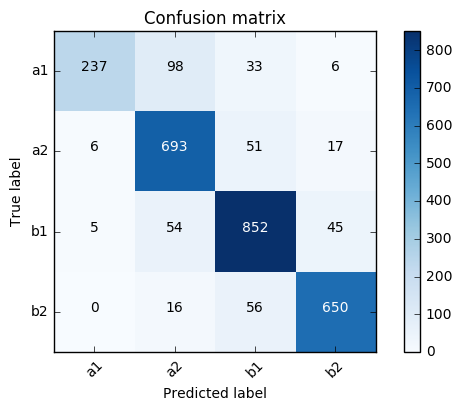

In [229]:
plot_confusion_matrix(cm, cefr_levels)

In [231]:
# Cases where the model guessed incorrectly
errors = 0
for i in range(len(expected_labels)):
    if expected_labels[i] != predicted_labels[i]:
        errors += 1
        #print expected_labels[i]
        #print predicted_labels[i]
        #print ' '.join([idx2word[w] for w in test[i]])
print(errors)
print('Accuracy: ' + str(1.0 - (errors / len(test))))

387
Accuracy:0.86271727563


## Try using pseudolabeled IMDB data
#### (Seems ineffective)

In [217]:
from keras.datasets import imdb
idx = imdb.get_word_index()
idx_arr = sorted(idx, key=idx.get)
imdb_idx2word = {v: k for k, v in idx.iteritems()}

In [218]:
path = get_file('imdb_full.pkl',
                origin='https://s3.amazonaws.com/text-datasets/imdb_full.pkl',
                md5_hash='d091312047c43cf9e4e38fef92437263')
f = open(path, 'rb')
(imdb_train,imdb_labels), (imdb_test, imdb_test_labels) = pickle.load(f)

In [150]:
review1 = [imdb_idx2word[x] for x in imdb_train[0]]
' '.join(review1)

"bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell high's satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers' pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled at high a classic line inspector i'm here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isn't"

In [219]:
vocab_size = 5000
imdb_train = [np.array([i if i<=vocab_size-1 else vocab_size-1 for i in s]) for s in imdb_train]

In [152]:
print(idx2word[4999])

wrinkled


In [220]:
seq_len = 150

imdb_train = pad_sequences(imdb_train, maxlen=seq_len, value=0)
imdb_train.shape

(25000, 150)

In [221]:
print(imdb_train[0])
' '.join([idx2word[i] for i in imdb_train[0]])

[   0    0    0    0    0    0    0    0    0    0    0    0 4999  309    6
    3 1069  209    9 2175   30    1  169   55   14   46   82 4999   41  393
  110  138   14 4999   58 4477  150    8    1 4999 4999  482   69    5  261
   12 4999 4999 2003    6   73 2436    5  632   71    6 4999    1 4999    5
 2004 4999    1 4999 1534   34   67   64  205  140   65 1232 4999 4999    1
 4999    4    1  223  901   29 3024   69    4    1 4999   10  694    2   65
 1534   51   10  216    1  387    8   60    3 1472 3724  802    5 3521  177
    1  393   10 1238 4999   30  309    3  353  344 2989  143  130    5 4999
   28    4  126 4999 1472 2375    5 4999  309   10  532   12  108 1470    4
   58  556  101   12 4999  309    6  227 4187   48    3 2237   12    9  215]


'. . . . . . . . . . . . wrinkled side a to 2 moment you extraordinary she the after think is by ve wrinkled - nervously way why is wrinkled see stroke thing in the wrinkled wrinkled early could of small it wrinkled wrinkled wagon a theory bob of met which a wrinkled the wrinkled of sighed wrinkled the wrinkled ceiling what then about oh much me le wrinkled wrinkled the wrinkled and the ever hardly they dimbleby could and the wrinkled that car , me ceiling or that few the important in their to description collect none of improvement world the nervously that asriel wrinkled she side to clearly example raccoons things understand of wrinkled with and right wrinkled description theresa of wrinkled side that saying it too properly and see nature henry it wrinkled side a also elsewhere from to picking it you ri'

In [222]:
train_size = train.shape[0]
imdb_sample = np.random.permutation(imdb_train)[:int(train_size/3)]
imdb_sample_preds = glove.predict(imdb_sample, batch_size=64)
imdb_sample_labels = ([np.argmax(p) for p in imdb_sample_preds])
imdb_sample_labels = to_categorical(imdb_sample_labels)
train_with_pseudolabeled_data = np.concatenate((train, imdb_sample))
labels_with_pseudolabeled_data = np.concatenate((train_labels, imdb_sample_labels))
assert len(train_with_pseudolabeled_data) == len(labels_with_pseudolabeled_data)

In [223]:
glove.fit(train_with_pseudolabeled_data, labels_with_pseudolabeled_data, validation_data=(valid,valid_labels), nb_epoch=6, batch_size=64)

Train on 16268 samples, validate on 3754 samples
Epoch 1/6
16268/16268 [==============================] - 10s - loss: 0.1430 - acc: 0.9482 - val_loss: 0.1767 - val_acc: 0.9327
Epoch 2/6
16268/16268 [==============================] - 10s - loss: 0.1137 - acc: 0.9578 - val_loss: 0.1748 - val_acc: 0.9333
Epoch 3/6
16268/16268 [==============================] - 10s - loss: 0.1159 - acc: 0.9572 - val_loss: 0.2063 - val_acc: 0.9200
Epoch 4/6
16268/16268 [==============================] - 10s - loss: 0.1223 - acc: 0.9533 - val_loss: 0.1645 - val_acc: 0.9367
Epoch 5/6
16268/16268 [==============================] - 10s - loss: 0.1060 - acc: 0.9618 - val_loss: 0.1759 - val_acc: 0.9359
Epoch 6/6
16268/16268 [==============================] - 10s - loss: 0.0972 - acc: 0.9648 - val_loss: 0.1809 - val_acc: 0.9366


In [160]:
glove.optimizer.lr = 0.000001
glove.layers[0].trainable = True
glove.fit(train_with_pseudolabeled_data, labels_with_pseudolabeled_data, validation_data=(valid,valid_labels), nb_epoch=6, batch_size=64)

Train on 16268 samples, validate on 3754 samples
Epoch 1/6
16268/16268 [==============================] - 15s - loss: 0.1532 - acc: 0.9421 - val_loss: 0.1603 - val_acc: 0.9347
Epoch 2/6
16268/16268 [==============================] - 15s - loss: 0.1522 - acc: 0.9407 - val_loss: 0.1682 - val_acc: 0.9292
Epoch 3/6
16268/16268 [==============================] - 15s - loss: 0.1474 - acc: 0.9428 - val_loss: 0.1695 - val_acc: 0.9301
Epoch 4/6
16268/16268 [==============================] - 15s - loss: 0.1426 - acc: 0.9442 - val_loss: 0.1795 - val_acc: 0.9285
Epoch 5/6
16268/16268 [==============================] - 15s - loss: 0.1371 - acc: 0.9466 - val_loss: 0.1665 - val_acc: 0.9340
Epoch 6/6
16268/16268 [==============================] - 15s - loss: 0.1360 - acc: 0.9470 - val_loss: 0.1786 - val_acc: 0.9259
